In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
df = pd.read_csv("admit.csv")
df.head()

,admit,gre,gpa,rank
0,0,380,3.61,3
1,1,660,3.67,3
2,1,800,4.00,1
3,1,640,3.19,4
4,0,520,2.93,4


In [2]:
df.shape

(400, 4)

In [3]:
df.dtypes

admit      int64
gre        int64
gpa      float64
rank       int64
dtype: object

In [4]:
df.describe()

,admit,gre,gpa,rank
count,400.000000,400.000000,400.000000,400.00000
mean,0.317500,587.700000,3.389900,2.48500
std,0.466087,115.516536,0.380567,0.94446
min,0.000000,220.000000,2.260000,1.00000
25%,0.000000,520.000000,3.130000,2.00000
50%,0.000000,580.000000,3.395000,2.00000
75%,1.000000,660.000000,3.670000,3.00000
max,1.000000,800.000000,4.000000,4.00000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe240556f28>,
      dtype=object)

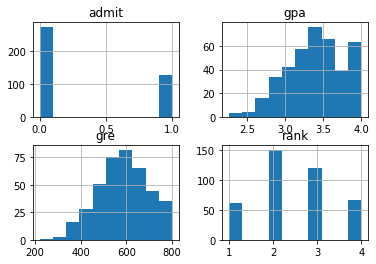

In [6]:
import pylab as pl
import matplotlib.pyplot as plt
df.hist()

In [6]:
# dummify rank
dummy_ranks = pd.get_dummies(df['rank'], prefix='rank')
dummy_ranks.head()

,rank_1,rank_2,rank_3,rank_4
0,0,0,1,0
1,0,0,1,0
2,1,0,0,0
3,0,0,0,1
4,0,0,0,1


In [7]:
# add dummy variables
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'rank_2':])
data.head()

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


,admit,gre,gpa,rank_2,rank_3,rank_4
0,0,380,3.61,0,1,0
1,1,660,3.67,0,1,0
2,1,800,4.00,0,0,0
3,1,640,3.19,0,0,1
4,0,520,2.93,0,0,1


In [8]:
X=data[['gre','gpa','rank_2','rank_3','rank_4']]
y=data['admit']

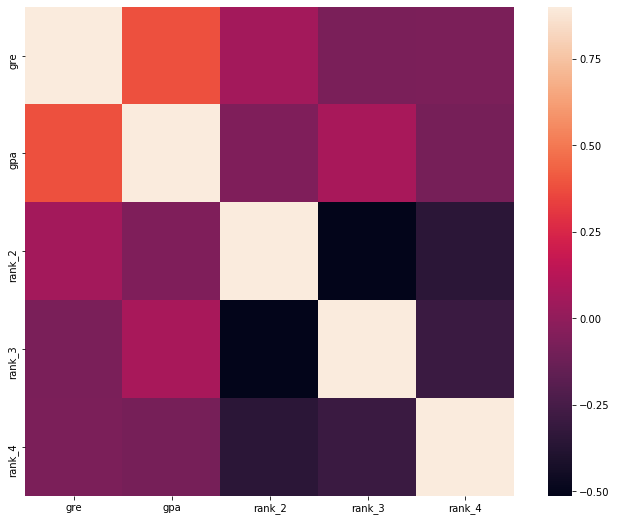

In [9]:
# check multicolinearity of predictors
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
corrmat = X.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [10]:
# VIF
cc = np.corrcoef(X, rowvar=False)
VIF = np.linalg.inv(cc)
VIF.diagonal()  # all vifs are below 5, no multicolinearity

array([1.19474169, 1.19458531, 2.17781047, 2.10428793, 1.77306746])

In [36]:
from sklearn import linear_model
logit = linear_model.LogisticRegression()

In [37]:
logit.fit(X,y)

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [38]:
logit.coef_

array([[ 0.00239206,  0.72455301, -0.47062895, -1.08794937, -1.23617382]])

In [39]:
colnames = ['gre','gpa','rank_2','rank_3','rank_4']
result = pd.DataFrame(logit.coef_)
result.columns = colnames
result['intercept'] = logit.intercept_ 
result = result.transpose()
result.columns = ['coefficient on the log odds scale']
result

,coefficient on the log odds scale
gre,0.002392
gpa,0.724553
rank_2,-0.470629
rank_3,-1.087949
rank_4,-1.236174
intercept,-3.987526


In [29]:
np.exp(logit.coef_)

array([[1.00134018, 0.82917667, 0.47912396, 0.27977431, 0.21790516]])

In [40]:
colnames = ['gre','gpa','rank_2','rank_3','rank_4']
result = pd.DataFrame(np.exp(logit.coef_))
result.columns = colnames
result['intercept'] =np.exp(logit.intercept_)
result = result.transpose()
result.columns = ['coefficient on the odds scale']
result

,coefficient on the odds scale
gre,1.002395
gpa,2.063808
rank_2,0.624609
rank_3,0.336907
rank_4,0.290494
intercept,0.018546


In [41]:
# predict 0,1
data['pred'] = logit.predict(X)

In [42]:
# predict the probability of 1
data['pred_prob']=logit.predict_proba(X)[:,1]
data.head()

,admit,gre,gpa,rank_2,rank_3,rank_4,pred,pred_prob
0,0,380,3.61,0,1,0,0,0.174962
1,1,660,3.67,0,1,0,0,0.302038
2,1,800,4.00,0,0,0,1,0.695155
3,1,640,3.19,0,0,1,0,0.200775
4,0,520,2.93,0,0,1,0,0.135066


In [43]:
from sklearn.metrics import accuracy_score
accuracy_score(data['admit'], data['pred'])

0.705

In [44]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, thresholds =roc_curve(data['admit'], data['pred'])
roc_auc = auc(fpr, tpr)
print("Area under the ROC curve : %f" % roc_auc)

Area under the ROC curve : 0.571227


In [46]:
#X2 = sm.add_constant(X)
model = sm.Logit(y, X)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.589306
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  400
Model:                          Logit   Df Residuals:                      395
Method:                           MLE   Df Model:                            4
Date:                Fri, 25 Sep 2020   Pseudo R-squ.:                 0.05707
Time:                        22:18:14   Log-Likelihood:                -235.72
converged:                       True   LL-Null:                       -249.99
Covariance Type:            nonrobust   LLR p-value:                 9.732e-06
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
gre            0.0014      0.001      1.329      0.184      -0.001       0.003
gpa           -0.1336      0.194     -0.687      0.492      -0.515       0.248
rank_2        -0.9663      0.300     -3.216      0.001      -1.555      -0.377
rank_3        -1.5451      0.332     -4.648      0.000      -2.197      -0.894
rank_4        -1.8776      0.402     -4.676      0.000      -2.665      -1.091
==============================================================================
"""

In [47]:
result.conf_int()# log odds scale

,0,1
gre,-0.000659,0.003433
gpa,-0.514719,0.247567
rank_2,-1.555108,-0.377455
rank_3,-2.196552,-0.893587
rank_4,-2.664598,-1.090586


In [48]:
np.exp(result.conf_int()) # odds scale

,0,1
gre,0.999341,1.003439
gpa,0.597669,1.280906
rank_2,0.211167,0.685604
rank_3,0.111186,0.409185
rank_4,0.069627,0.336019


In [27]:
# only rank is significant, gre and gpa are not significant
# overall regression is significant
# mcfadden pseudo rl2: 0.05707

In [7]:
import numpy as np
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

In [8]:
# Load data
iris = datasets.load_iris()
X = iris.data
y = iris.target

In [9]:
# Create logistic regression
logistic = linear_model.LogisticRegression()

In [10]:
logistic.fit(X,y)

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [11]:
pred=logistic.predict(X)

In [12]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y, pred)

0.9733333333333334

In [13]:
confusion_matrix(y, pred)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  1, 49]])

In [11]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

In [12]:
# Create grid search using 5-fold cross validation
clf = GridSearchCV(logistic, hyperparameters, cv=5, scoring='accuracy')

In [13]:
# Fit grid search
best_model = clf.fit(X, y)

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: Converg

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/shuozhang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Us

In [14]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 7.742636826811269


In [15]:
pred=best_model.predict(X)

In [20]:
from sklearn.metrics import accuracy_score,confusion_matrix
accuracy_score(y, pred)

0.98

In [21]:
confusion_matrix(y, pred)

array([[50,  0,  0],
       [ 0, 48,  2],
       [ 0,  1, 49]])